In [ ]:
#install spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
#import library
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [ ]:
#spark session
from pyspark.sql import SparkSession
sp = SparkSession.builder.getOrCreate()

In [ ]:
#read csv
sp.read.csv("Customer.csv", header=True).createOrReplaceTempView("customer")
sp.read.csv("Part.csv", header=True).createOrReplaceTempView("part")
sp.read.csv("Supplier.csv", header=True).createOrReplaceTempView("supplier")
sp.read.csv("Staff.csv", header=True).createOrReplaceTempView("staff")
sp.read.csv("TransactionDetail.csv", header=True).createOrReplaceTempView("trans_detail")
sp.read.csv("TransactionHeader.csv", header=True).createOrReplaceTempView("trans_header")

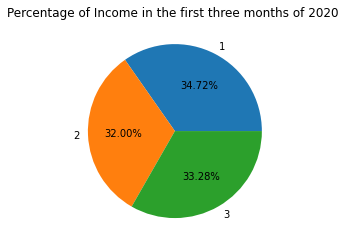

In [ ]:
#a.	Show the percentage of income within the first three months of year 2020 in which the part price is 500 and above using pie plot.
data = sp.sql("""
   select sum(b.quantity*a.price) as income, month(c.transactiondate) as month
   from part a join trans_detail b on a.partid = b.partid join trans_header c on b.transactionid = c.transactionid
   where year(c.transactiondate) = 2020 and month(c.transactiondate) between 1 and 3 and a.price >= 500
   group by month
   order by month
""").toPandas()

plt.pie(data["income"],labels=data["month"], autopct="%.2f%%")
plt.title("Percentage of Income in the first three months of 2020 ")
plt.show()




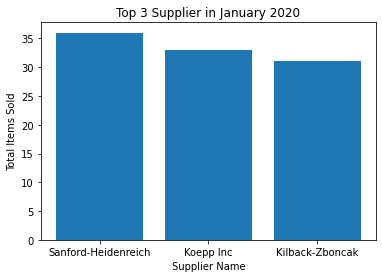

,name,totalSold
0,Sanford-Heidenreich,36.0
1,Koepp Inc,33.0
2,Kilback-Zboncak,31.0


In [ ]:
#b.	Show top 3 supplier in which the part is bought the most in January 2020 using bar plot.
data = sp.sql("""
  select a.name as name,sum(c.quantity) as totalSold
  from supplier a join part b on a.supplierid = b.supplierid join trans_detail c on b.partid = c.partid join trans_header d on c.transactionid = d.transactionid
  where year(d.transactiondate) = 2020 and month(d.transactiondate)= 1
  group by a.name
  order by sum(c.quantity) desc
  limit 3
""").toPandas()

plt.bar(data["name"], data["totalSold"])
plt.title('Top 3 Supplier in January 2020')
plt.xlabel('Supplier Name')
plt.ylabel('Total Items Sold')
plt.show()

display(data)

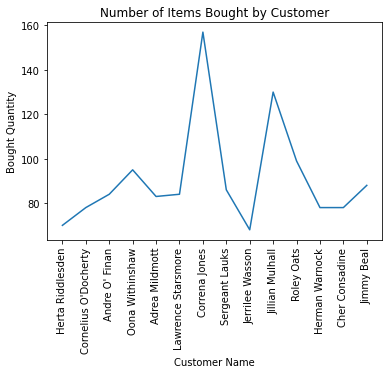

,bought,name
0,70.0,Herta Riddlesden
1,78.0,Cornelius O'Docherty
2,84.0,Andre O' Finan
3,95.0,Oona Withinshaw
4,83.0,Adrea Mildmott
5,84.0,Lawrence Starsmore
6,157.0,Correna Jones
7,86.0,Sergeant Lauks
8,68.0,Jerrilee Wasson
9,130.0,Jillian Mulhall


In [ ]:
#c.	Show the number of items bought by customer that has at least done multiple transaction with female staff and total items bought is more than 50 using line plot.
data = sp.sql("""
  select sum(d.Quantity) as bought, a.name as name
   
  from customer a join trans_header b on a.customerid = b.customerid join staff c on b.staffid = c.staffid join trans_detail d on b.transactionid = d.transactionid
  where c.gender = 'Female'
  group by a.name
  having sum(d.quantity) > 50 and count(b.transactionId) > 1
""").toPandas()

plt.plot(data["name"], data["bought"])
plt.title("Number of Items Bought by Customer")
plt.xlabel("Customer Name")
plt.ylabel("Bought Quantity")
plt.xticks(rotation=90)


plt.show()

display(data)

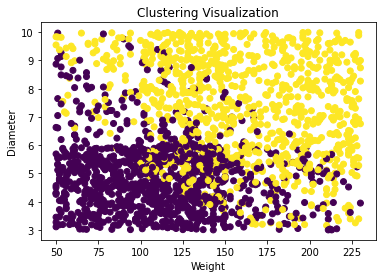

In [ ]:
#Clustering

#read csv
testing = sp.read.csv("TomatoTest.csv", header=True, inferSchema=True)
training = sp.read.csv("TomatoTrain.csv", header=True, inferSchema=True)

#select features
columns = ["Weight", "Diameter", "Color"]

#drop null values
testing = testing.na.drop()
training = training.na.drop()

#select column
testing = testing.select("Weight", "Diameter", "Color", "Hybrid")
training = training.select("Weight", "Diameter", "Color")

#data transform
testing = testing.withColumn(
    "Color",
    when(testing["Color"]=="Red", 0)
    .when(testing["Color"]=="Dark Red", 1)
    .otherwise(2)
    
)

testing = testing.withColumn(
    "Hybrid",
    when(testing["Hybrid"]=="No", 0).otherwise(1)
)

training = training.withColumn(
    "Color",
    when(training["Color"]=="Red", 0)
    .when(training["Color"]=="Dark Red", 1)
    .otherwise(2)
    
)

#normalize data
assembler = VectorAssembler(inputCols=columns, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

#clustering model
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

#visualization
plt.scatter(
    data["Weight"],
    data["Diameter"],
    c = data["prediction"]
)
plt.title("Clustering Visualization")
plt.xlabel("Weight")
plt.ylabel("Diameter")
plt.show()



In [ ]:
#accuracy
count = 0
for idx, row in data.iterrows():
  if row["Hybrid"] == row["prediction"]:
    count+=1
acc = count / len(data) * 100
print(f'Accuracy is {acc}%')

Accuracy is 80.9%
